<a href="https://colab.research.google.com/github/w15d0177/AIFFEL_quest_cr/blob/main/Exploration/Quest03/SAM_shared_by_Mansoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- SAM(Segment Anything Model)은 이미지에서 특정 객체나 영역을 자동으로 식별하고 분리(세그멘테이션)하는 AI 모델입니다.     
   
- 사전 학습된 강력한 비전 모델로, 특정 객체를 지목하거나, 텍스트로 지시하거나, 클릭만으로도 다양한 이미지의 세그멘테이션 작업을 수행할 수 있습니다.      
     
- 직관적이고 범용적으로 활용할 수 있는 것이 특징입니다.     


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mediapipe

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import mediapipe as mp

In [4]:
# `segment-anything` 레포지토리 클론
!git clone https://github.com/facebookresearch/segment-anything.git
%cd segment-anything

# 의존성 패키지 설치
!pip install -r requirements.txt

!pip install torch torchvision torchaudio

# 모델 체크포인트 다운로드
!rm sam_vit_h_4b8939.pth
!curl -O https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

fatal: destination path 'segment-anything' already exists and is not an empty directory.
/content/segment-anything
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2445M  100 2445M    0     0   162M      0  0:00:15  0:00:15 --:--:--  158M


/content/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


JihyeKIM.JPG 처리 완료. 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_SAM/portrait_JihyeKIM.JPG


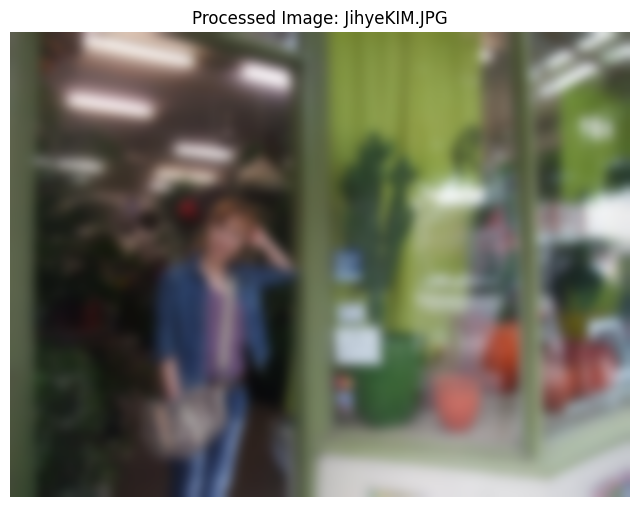

Jihye_KIM.jpg 처리 완료. 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_SAM/portrait_Jihye_KIM.jpg


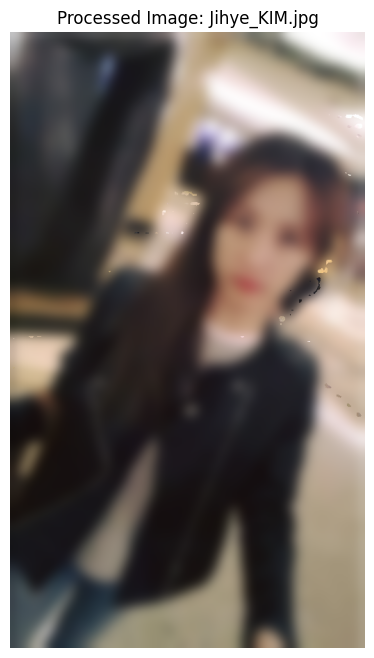

In [5]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# SAM 모델 초기화
model_type = "vit_h"  # 'vit_h', 'vit_l', 'vit_b' 등의 버전을 사용할 수 있음
sam = sam_model_registry[model_type](checkpoint="sam_vit_h_4b8939.pth")  # 모델 체크포인트 경로 수정
sam.to(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
predictor = SamPredictor(sam)

# 이미지 경로 설정
image_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus_data'
output_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_SAM'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)
    image = cv2.imread(img_path)

    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # SAM을 사용하여 인물과 배경을 분리
    predictor.set_image(image)
    masks, _, _ = predictor.predict(point_coords=None, point_labels=None, multimask_output=False)

    # 세그멘테이션 마스크 생성
    mask = masks[0]  # 첫 번째 마스크를 사용
    mask = mask.astype(np.uint8) * 255  # 마스크를 0과 255로 변환

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 최종 이미지 생성 (인물은 원본 이미지, 배경은 흐리게 처리)
    mask_3ch = cv2.merge([mask, mask, mask])  # 마스크를 3채널로 확장
    output_image = np.where(mask_3ch == 255, image, blurred_bg)

    # 이미지 저장
    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리 완료. 저장: {output_path}")

    # 중간 처리과정 이미지 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Processed Image: {image_name}")
    plt.show()
